## Example for `.mat` files

In [21]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import rc

from deepdelineator.utils import load_delineator, loadmat

rc("font", **{"family": "serif", "serif": "Computer Modern"})
rc("text", usetex=True)

**model_type** pick one:

    1. U_NET <-- default
    2. TCN
    3. U_TCN
    5. U_GRU

In [22]:
model_type = "U_NET"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Deep Delineator is loaded (please check that PyTorch is installed)
model = load_delineator(model_type, device)

UNET


In [23]:
# Path of files
path_folder = "./signals"
# List of filenames in the path_file
file_names = os.listdir(path_folder)
file_names

['example4_VALS2_PA_Rad.mat',
 'example1_VALS2_PA_Rad.mat',
 'example6_VALS_PA_Car.mat',
 'example1_VALS2_PA_Car.mat',
 'example7_VALS_PA_Rad.mat',
 'example8_VALS2_PA_Rad.mat',
 'example7_VALS_PA_Car.mat',
 'example2_VALS_PA_Rad.mat',
 'example3_VALS_PA_Rad.mat',
 'example6_VALS_PA_Rad.mat',
 'example5_VALS_RAD.mat']

In [24]:
# Number of files
q_files = np.shape(file_names)[0]
# x_list = Input
x_list = []
for i_file in np.arange(0, q_files):
    # Load all the file
    file = loadmat(os.path.join(path_folder, file_names[i_file]))
    key = list(file.keys())[-1]
    x_i = file[key]
    x_list.append(x_i)

In [25]:
# Random Samples from the files
sgn = np.random.randint(0, high=q_files)

print("Type of input: {} ".format(type(x_list)))
print("Type of each signal: {}".format(type(x_list[sgn])))
print("Shape of each signal: {} ==> (lenght,)".format(np.shape(x_list[sgn])))

Type of input: <class 'list'> 
Type of each signal: <class 'numpy.ndarray'>
Shape of each signal: (23898,) ==> (lenght,)


## Detections

At this point, there is a list with $N$ signals in format of np.ndarray, with a shape of (lenght,) each one

In [26]:
# Sampling frecuency of the signals
s_f = 500
# Detection!
detections = model.pred_from_numpy(x_list, s_f=s_f)

In [27]:
# Let's see what is 'detections' and how is conformed
print(f"detections is a : {type(detections)}")
print(f"and its keys are: {detections.keys()}")

detections is a : <class 'dict'>
and its keys are: dict_keys([np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)])


In [28]:
# Let's see how each detections_dict[index] is composed
detections[sgn].keys()

dict_keys(['original', 'resampled'])

In [29]:
# Let's see how each detections_dict[index]['original'] is composed
detections[sgn]["original"].keys()

dict_keys(['signal', 'predictions', 'onset', 'peaks', 'dn', 'beats_fips', 'artifacts', 's_f'])

In [30]:
# Let's see what is each detections_dict[index]['beats_fips']
type(detections[sgn]["original"]["beats_fips"])

numpy.ndarray

In [31]:
# And the shape is
beats_shape = np.shape(detections[sgn]["original"]["beats_fips"])

print(f"There are {beats_shape[0]} complete beats")

There are 32 complete beats


Where for the second dimension:
   * [indx,0] $\rightarrow$ onset, 
   * [indx,1] $\rightarrow$ peak
   * [indx,2] $\rightarrow$ dicrotic notch
   * [indx,3] $\rightarrow$ end of the beat

In [32]:
# And the type of artifacts are
type(detections[sgn]["original"]["artifacts"])

numpy.ndarray

In [33]:
# With shape
type(detections[sgn]["original"]["artifacts"])

numpy.ndarray

In [34]:
# Let's see the artifact dimensions
artifact_shape = np.shape(detections[sgn]["original"]["artifacts"])
print(f"There are {artifact_shape[0]} regions with artifacts")

There are 27 regions with artifacts


The first dimension is the number artifact's regions and the second mean [start,end] indexes

In [35]:
if artifact_shape[0] > 0:
    print("Start index: ", detections[sgn]["original"]["artifacts"][0, 0])
    print("End index: ", detections[sgn]["original"]["artifacts"][0, 1])

Start index:  2399
End index:  2411


## Plot detections

Finally, let's see the detections output in the original frecuency

**P.S.:**

**Deep_Delineator works in a batch way and it trough out the last samples that not complet a batch.**

10


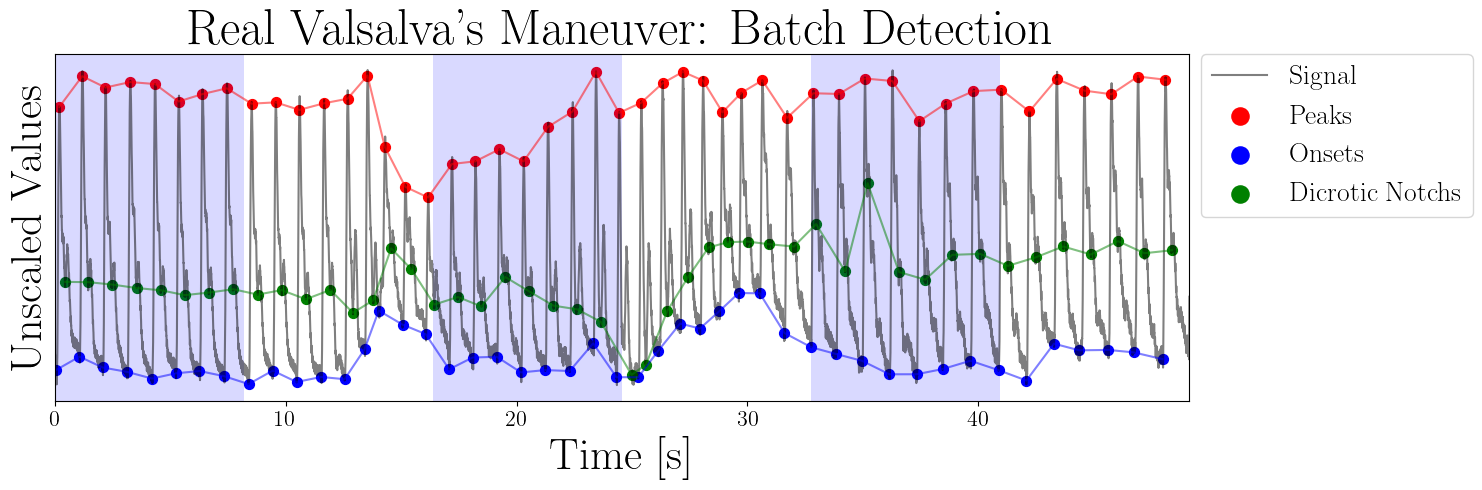

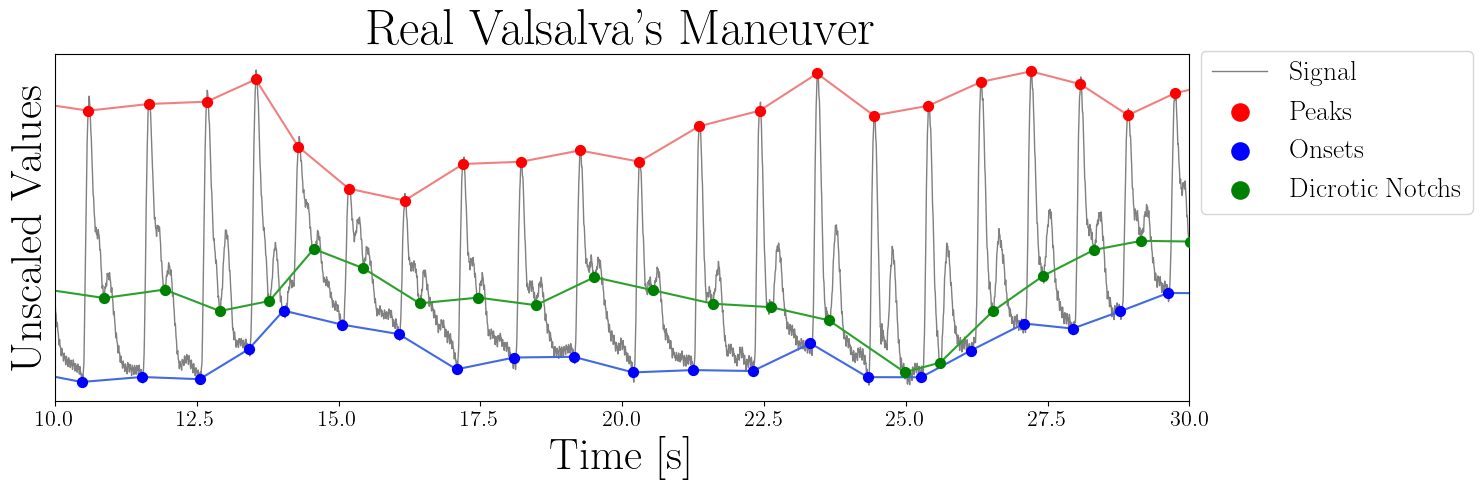

In [36]:
# Random Samples from the files
sgn = np.random.randint(0, high=q_files)
print(sgn)
sgn = 1
frec = "original"
s_f_plot = detections[sgn][frec]["s_f"]
signal = detections[sgn][frec]["signal"]
n_batchs = (
    len(signal) * 125 / (s_f_plot * 1024)
)  # 125 Hz of the trained model, 1024 samples a batch
peak_idx = detections[sgn][frec]["peaks"]
onset_idx = detections[sgn][frec]["onset"]
dn_idx = detections[sgn][frec]["dn"]
peak_val = signal[peak_idx]
onset_val = signal[onset_idx]
dn_val = signal[dn_idx]

peak_time = peak_idx / s_f_plot
onset_time = onset_idx / s_f_plot
dn_time = dn_idx / s_f_plot

t_vec = np.arange(0, len(signal)) / s_f_plot

# plt.figure(figsize=(15, 5))
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax0.plot(t_vec, signal, c="black", alpha=0.5, label="Signal")

ax0.plot(
    peak_time,
    peak_val,
    c="r",
    alpha=0.5,
)
ax0.plot(onset_time, onset_val, c="b", alpha=0.5)
ax0.plot(dn_time, dn_val, c="g", alpha=0.5)
ax0.scatter(peak_time, peak_val, c="r", label="Peaks", s=50)
ax0.scatter(onset_time, onset_val, c="b", label="Onsets", s=50)
ax0.scatter(dn_time, dn_val, c="g", label="Dicrotic Notchs", s=50)
# ax0.legend(fontsize=16)
ax0.set_title("Real Valsalva's Maneuver: Batch Detection", fontsize=36)
ax0.set_xlabel("Time [s]", fontsize=32)
ax0.set_ylabel("Unscaled Values", fontsize=32)
ax0.set_xlim(0, t_vec[-1])
ax0.set_yticks([])
ax0.tick_params(axis="x", which="major", labelsize=16)

# To explicit the different batch analized
for i in np.arange(0, len(signal) / s_f_plot, (1024 * 2) / 125):
    plt.axvspan(i, i + 1024 / 125, facecolor="b", alpha=0.15)
ax0.legend(
    bbox_to_anchor=(1.01, 1, 0.24, 0),
    markerscale=1.75,  # loc="lower left",
    mode="expand",
    borderaxespad=0,
    fontsize=20,
)

plt.tight_layout()
plt.savefig("full_real_signal.pdf", dpi=300)
plt.show()

## Only Fiducial points from compelted beats
signal = detections[sgn][frec]["signal"]
peak_idx = detections[sgn][frec]["beats_fips"][:, 1]
onset_idx = detections[sgn][frec]["beats_fips"][:, 0]
dn_idx = detections[sgn][frec]["beats_fips"][:, 2]
peak_val = signal[peak_idx]
onset_val = signal[onset_idx]
dn_val = signal[dn_idx]

peak_time = peak_idx / s_f_plot
onset_time = onset_idx / s_f_plot
dn_time = dn_idx / s_f_plot


fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax0.plot(t_vec, signal, c="grey", label="Signal", linewidth=1, zorder=1)
ax0.plot(peak_time, peak_val, c="lightcoral", zorder=2)
ax0.plot(onset_time, onset_val, c="royalblue", zorder=2)
ax0.plot(dn_time, dn_val, c="tab:green", zorder=2)
ax0.scatter(peak_time, peak_val, c="r", label="Peaks", zorder=3, s=50)
ax0.scatter(onset_time, onset_val, c="b", label="Onsets", zorder=3, s=50)
ax0.scatter(dn_time, dn_val, c="g", label="Dicrotic Notchs", zorder=3, s=50)
ax0.set_xlim(10, 30)
ax0.set_xlabel("Time [s]", fontsize=32)
ax0.set_ylabel("Unscaled Values", fontsize=32)
ax0.set_yticks([])
ax0.tick_params(axis="x", which="major", labelsize=16)

# plt.xlim(0,t_vec[-1])
ax0.set_title("Real Valsalva's Maneuver", fontsize=36)
# ax0.legend(fontsize=16)
# plt.legend(bbox_to_anchor=(0.836,1.04),fontsize=16, borderaxespad=0)
ax0.legend(
    bbox_to_anchor=(1.01, 0.54, 0.24, 0),
    markerscale=1.75,  # loc="lower left",
    mode="expand",
    borderaxespad=0,
    fontsize=20,
)
# To explicit the different batch analized
# for i in np.arange(0, len(signal)/s_f_plot,(1024*2)/125):
#    plt.axvspan(i, i+1024/125, facecolor='lightsteelblue',zorder=0)
plt.tight_layout()
plt.savefig("real_signal.pdf", dpi=300)
plt.show()